In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Not running in Colab, skipping Google Drive mount.")

Mounted at /content/drive


Loaded 7165 frames from 1433 videos.
Loaded 800 frames from 160 videos.
Loaded 2035 frames from 407 videos.
Starting training for 10 epochs...


 Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 1/10:   0%|          | 0/896 [00:00<?, ?it/s]

 Epoch 1 - Train Loss: 439.9094, Train Acc: 0.7699, Val Acc: 0.8825
✓ Saved new best model


 Epoch 2/10:   0%|          | 0/896 [00:00<?, ?it/s]

 Epoch 2 - Train Loss: 305.6627, Train Acc: 0.8784, Val Acc: 0.8750


 Epoch 3/10:   0%|          | 0/896 [00:00<?, ?it/s]

 Epoch 3 - Train Loss: 264.9606, Train Acc: 0.8920, Val Acc: 0.9050
✓ Saved new best model


 Epoch 4/10:   0%|          | 0/896 [00:00<?, ?it/s]

 Epoch 4 - Train Loss: 253.0594, Train Acc: 0.8977, Val Acc: 0.9163
✓ Saved new best model


 Epoch 5/10:   0%|          | 0/896 [00:00<?, ?it/s]

 Epoch 5 - Train Loss: 240.4009, Train Acc: 0.9069, Val Acc: 0.9062


 Epoch 6/10:   0%|          | 0/896 [00:00<?, ?it/s]

 Epoch 6 - Train Loss: 228.2653, Train Acc: 0.9091, Val Acc: 0.9187
✓ Saved new best model


 Epoch 7/10:   0%|          | 0/896 [00:00<?, ?it/s]

 Epoch 7 - Train Loss: 211.8500, Train Acc: 0.9186, Val Acc: 0.9263
✓ Saved new best model


 Epoch 8/10:   0%|          | 0/896 [00:00<?, ?it/s]

 Epoch 8 - Train Loss: 196.3402, Train Acc: 0.9232, Val Acc: 0.9250


 Epoch 9/10:   0%|          | 0/896 [00:00<?, ?it/s]

 Epoch 9 - Train Loss: 190.7891, Train Acc: 0.9248, Val Acc: 0.9325
✓ Saved new best model


 Epoch 10/10:   0%|          | 0/896 [00:00<?, ?it/s]

 Epoch 10 - Train Loss: 185.1319, Train Acc: 0.9280, Val Acc: 0.9313

 Evaluating on test set...


 Evaluating:   0%|          | 0/255 [00:00<?, ?it/s]


 Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.94      0.94      1000
        Fake       0.95      0.94      0.94      1035

    accuracy                           0.94      2035
   macro avg       0.94      0.94      0.94      2035
weighted avg       0.94      0.94      0.94      2035

 Confusion Matrix:
[[944  56]
 [ 61 974]]


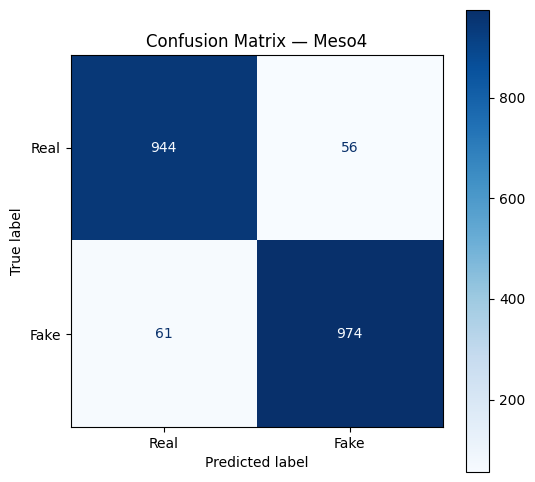

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm, trange
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random

# === CONFIG ===
DATA_DIR = Path("/content/drive/MyDrive/FakeAVCeleb/frames")  
TRAIN_CSV = Path("/content/drive/MyDrive/FakeAVCeleb/train_fixed_fullschema_hashsplit.csv")
TEST_CSV  = Path("/content/drive/MyDrive/FakeAVCeleb/test_fixed_fullschema_hashsplit.csv")
BATCH_SIZE = 8
EPOCHS = 10
IMG_SIZE = 256
NUM_CLASSES = 2
FRAMES_PER_VIDEO = 5  # sample per video to speed up + reduce redundancy

# === TRANSFORMS ===
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === DATASET ===
class FrameDataset(Dataset):
    def __init__(self, df, transform=None, frames_per_video=None):
        self.transform = transform
        self.samples = []

        for _, row in df.iterrows():
            vid_id = row['sample_id']
            label = int(row['video_fake'])
            folder = DATA_DIR / vid_id
            if folder.exists():
                frames = sorted(folder.glob("frame_*.jpg"))
                if frames_per_video and len(frames) > frames_per_video:
                    frames = random.sample(frames, frames_per_video)
                for f in frames:
                    self.samples.append((f, label))

        print(f"Loaded {len(self.samples)} frames from {len(df)} videos.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# === MESONET ARCHITECTURE ===
class Meso4(nn.Module):
    def __init__(self, num_classes=2):
        super(Meso4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 8, kernel_size=3, padding=1), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(16 * (IMG_SIZE // 16) * (IMG_SIZE // 16), 16)
        self.fc2 = nn.Linear(16, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === LOAD DATA ===
train_df_full = pd.read_csv(TRAIN_CSV)
train_df, val_df = train_test_split(train_df_full, test_size=0.1, stratify=train_df_full['video_fake'], random_state=42)
test_df = pd.read_csv(TEST_CSV)

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_df_full['video_fake']),
                                     y=train_df_full['video_fake'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

train_dataset = FrameDataset(train_df, transform=train_transform, frames_per_video=FRAMES_PER_VIDEO)
val_dataset   = FrameDataset(val_df, transform=val_test_transform, frames_per_video=FRAMES_PER_VIDEO)
test_dataset  = FrameDataset(test_df, transform=val_test_transform, frames_per_video=FRAMES_PER_VIDEO)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# === INIT MODEL ===
model = Meso4(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# === TRAIN LOOP ===
print(f"Starting training for {EPOCHS} epochs...")
best_val_acc = 0.0

for epoch in trange(EPOCHS, desc=" Training Progress"):
    model.train()
    total_loss, correct = 0, 0

    for images, labels in tqdm(train_loader, desc=f" Epoch {epoch+1}/{EPOCHS}", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = correct / len(train_dataset)

    # === VALIDATION ===
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = np.mean(np.array(val_preds) == np.array(val_labels))
    print(f" Epoch {epoch+1} - Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "meso4_best.pth")
        print("✓ Saved new best model")

# === TEST EVAL ===
print("\n Evaluating on test set...")
model.load_state_dict(torch.load("meso4_best.pth", map_location=device))
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc=" Evaluating"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))

print(" Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# === PLOT CM ===
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix — Meso4")
plt.show()


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/FakeAVCeleb/mesonet.pth")